In [1]:
import arviz as az
import preliz as pz
import pandas as pd
import json
import os

import numpy as np
import diffrax
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import seaborn as sns
import jax
import sys
from scipy.stats import mode
from scipy.stats import mannwhitneyu
from scipy.stats import ks_2samp
from tqdm import tqdm


sys.path.append("../models/")
from huang_ferrell_1996 import *
from bhalla_iyengar_1999 import *
from kholodenko_2000 import *
from levchenko_2000 import *
from hornberg_2005 import *
from birtwistle_2007 import *
from orton_2009 import *
from vonKriegsheim_2009 import *
from shin_2014 import *
from ryu_2015 import *
from kochanczyk_2017 import *


jax.config.update("jax_enable_x64", True)

sys.path.insert(0, '../')
from utils import *

rng = np.random.default_rng(seed=1234)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [3]:
################ LOAD in DATA ################
datadir = '../../../results/MAPK/param_est/Keyes_2020_data/'
savedir = datadir + 'compartment_diffs/'
if not os.path.exists(savedir):
    os.makedirs(savedir)

# load in the model info 
model_info = json.load(open('model_info.json', 'r'))
model_names = list(model_info.keys())
display_names = [model_info[model]['display_name'] for model in model_names]

idata = {'CYTO':{},'PM':{}}
posterior_samples = {'CYTO':{},'PM':{}}
sample_times = {'CYTO':{},'PM':{}}

for model in model_names:
    for compartment in ['CYTO','PM']:
        idata[compartment][model], _, sample_times[compartment][model] = load_smc_samples_to_idata(datadir+compartment+'/' + model + '/' + model +'_smc_samples.json', sample_time=True)
        posterior_samples[compartment][model] = np.load(datadir+compartment+'/' + model + '/' + model +'_posterior_predictive_samples.npy')

# load in the training data
dat = {'CYTO':{'inputs':None, 'data':None,'data_std':None, 'times':None},
       'PM':{'inputs':None, 'data':None,'data_std':None, 'times':None}}
dat['CYTO']['inputs'], dat['CYTO']['data'], dat['CYTO']['data_std'], \
    dat['CYTO']['times'] = load_data_json('../../../results/MAPK/Keyes_et_al_2020-fig1-data1-v2-CYTO.json', data_std=True, time=True)
dat['PM']['inputs'], dat['PM']['data'], dat['PM']['data_std'], \
    dat['PM']['times'] = load_data_json('../../../results/MAPK/Keyes_et_al_2020-fig1-data1-v2-PM.json', data_std=True, time=True)
data_time_to_mins = 60

In [4]:
upper_mult = 1e2
lower_mult = 1e-2
prob_mass_bounds = 0.95
plot_prior = False

stats = {}

for model in model_names:
    print(model)
    model_stats = {}
    free_params = model_info[model]['free_params'].split(',')
    prior_params = eval(model_info[model]['prior_family'])

    # try calling the model
    try:
        model_func = eval(model + '(transient=False)')
    except:
        print('Warning Model {} not found. Skipping this.'.format(args.model))

    # make the directory
    sdir = savedir + model + '/'
    if not os.path.exists(sdir):
        os.makedirs(sdir)

    # get parameter names and initial conditions
    p_dict, plist = model_func.get_nominal_params()

    for i, param in enumerate(free_params): 
        fig, ax = get_sized_fig_ax(0.5,0.3)
    
        cyto = np.squeeze(np.reshape(np.array(idata['CYTO'][model].posterior[param]), (-1,1)))
        pm = np.squeeze(np.reshape(np.array(idata['PM'][model].posterior[param]), (-1,1)))

        
        # plot eCDFs of CYTO and PM
        dat = pd.DataFrame({'CYTO':cyto, 'PM':pm})
        sns.ecdfplot(dat, ax=ax, 
                    palette=['blue', 'black'], 
                    legend=False, linewidth=1.5)
        # xlim = ax.get_xlim()
        
        # plot the prior
        if plot_prior:
            # get the prior info
            if p_dict[param] == 0:
                upper = 1.0
                lower = 1e-4
            else:
                # get the upper and lower bounds
                upper = p_dict[param]*upper_mult
                lower = p_dict[param]*lower_mult
            dist_family = eval('pz.' + prior_params[i][0])
            prior_mean = float(prior_params[0][0].split('mu')[1].strip('=)')) # strip out prior mean and convert to float
            _, results = pz.maxent(dist_family, lower, upper, prob_mass_bounds, plot=False)
            prior = pz.distributions.continuous.LogNormal(mu=prior_mean, sigma=results['x'])

            x = np.logspace(np.log(np.min(np.stack((cyto, pm)))), np.log(np.max(np.stack((cyto, pm)))), 1000)
            ax.plot(x, prior.cdf(x), color='black', linestyle='--', linewidth=1.0)

        # plot setup
        ax.set_title(param, fontweight='normal', fontsize=10.0)
        ax.set_ylim([0.0, 1.01])
        ax.set_xscale('log')
        ax.tick_params(axis='both', which='major', labelsize=8.0)
        # ax.set_ylabel(r'$P($'+'{}'.format(param)+r'$\leq x)$', fontsize=10.0)
        ax.set_ylabel('', fontsize=10.0)
        ax.set_xlabel('', fontsize=10.0)    

        # compute stats and add text label
        mwu = mannwhitneyu(cyto, pm, alternative='two-sided')
        ks = ks_2samp(cyto, pm, alternative='two-sided')
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        # text = 'Mann-Whitney p<0.05: {mw} \n KS:{ks} \n median_cyto: {mc:.3e} \n median_pm {mp:.3e}'.format(mw=mwu.pvalue<0.05, ks=ks.pvalue<0.05, mc=np.median(cyto), mp=np.median(pm))
        text = 'MW U-test:\n  p={mw:.2e}'.format(mw=mwu.pvalue)
        if mwu.pvalue<0.05:
            med_cyto = np.median(cyto)
            med_pm = np.median(pm)
            med_diff = med_cyto-med_pm
            med_med = np.median([med_cyto, med_pm])
            text += '\nMedian diff %:\n  {mc_diff:.2f}'.format(mc_diff=100*med_diff/med_med)
            # +r'$100\times\frac{Med(CYTO)-Med(PM)}{Med(CYTO,PM)}$'
        ax.text(1.1, 0.3, text, fontsize=8.0, transform=ax.transAxes, ha='left', va='center')

        # save the figure
        fig.savefig(sdir + param + '_ecdf.pdf', transparent=True, bbox_inches='tight')

        plt.close(fig)

        # store stats
        if mwu.pvalue<0.05:
            model_stats[param] = {'mwu':mwu.pvalue, 'mw_sig':int(mwu.pvalue<0.05), 'ks':ks.pvalue, 'med_cyto':np.median(cyto), 'med_pm':np.median(pm), 'med_diff_perc':100*med_diff/med_med}
        else:
            model_stats[param] = {'mwu':mwu.pvalue, 'mw_sig':int(mwu.pvalue<0.05), 'ks':ks.pvalue, 'med_cyto':np.nan, 'med_pm':np.nan, 'med_diff_perc':np.nan}
    stats[model] = model_stats 

# Save the stats variable to a JSON file
with open(savedir + 'stats.json', "w") as json_file:
    json.dump(stats, json_file, indent=4)

huang_ferrell_1996
kholodenko_2000
levchenko_2000
hornberg_2005
birtwistle_2007
orton_2009
vonKriegsheim_2009
shin_2014
ryu_2015
kochanczyk_2017


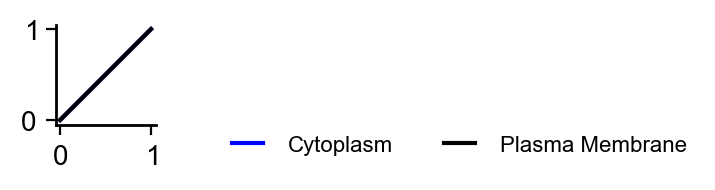

In [4]:
fig, ax = get_sized_fig_ax(0.5,0.5)
ax.plot([0,1], [0,1], color='blue', linewidth=1.5, label='Cytoplasm')
ax.plot([0,1], [0,1], color='black', linewidth=1.5, label='Plasma Membrane')
leg = ax.legend(loc='upper left', bbox_to_anchor=(1.5, 0.1), fontsize=8.0, ncol=2)
export_legend(leg, filename=savedir + 'ecdf_legend.pdf')

In [6]:
for model in model_names:
    new_dict = {pname:stats[model][pname]['mwu'] for pname in stats[model].keys() if stats[model][pname]['mwu']<0.05}
    pnames = np.array(list(new_dict.keys()))
    vals = np.abs(np.array(list(new_dict.values())))
    print(model)
    print(['{:.3f}'.format(val) for val in vals[np.argsort(vals)]])
    print(pnames[np.argsort(vals)])

huang_ferrell_1996
['0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.002', '0.014', '0.034']
['MKK_tot' 'k9' 'k8' 'MAPK_tot' 'MKKPase_tot' 'a8' 'k3' 'k4' 'a9' 'k7'
 'k10' 'd8' 'k1' 'a10' 'E2_tot' 'd7' 'a3' 'MKKK_tot' 'a1' 'a7' 'd3' 'a5']
kholodenko_2000
['0.000', '0.000', '0.000', '0.004', '0.011', '0.049']
['MAPK_total' 'K8' 'KI' 'v9' 'K10' 'v10']
levchenko_2000
['0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.002', '0.003', '0.003', '0.027', '0.042']
['MAPKPase' 'd10' 'MEKPase' 'total_scaffold' 'k6' 'a8' 'k9' 'a2' 'k2' 'k4'
 'a10' 'k10' 'kOff3' 'k3' 'a6' 'kOn2' 'a7' 'd2' 'k5']
hornberg_2005
['0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.005']
['kd55' 'k44' 'kd50' 'kd57' 'k42' 'kd58' 'kd53' 'kd45' 'kd47' 'k56' 'kd44'
 

In [40]:
stats['huang_ferrell_1996']['k10']

{'mwu': 4.281516308588201e-11,
 'mw_sig': 1,
 'ks': 3.279213740841629e-48,
 'med_cyto': 65.93612335888571,
 'med_pm': 50.83348883953214,
 'med_diff_perc': 25.867405457664443}

Make a table that shows similaries between compartment diffs in parameters across models. Load dat from excell file

In [15]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", grid_col='k', **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-90, ha="right",
             rotation_mode="anchor", fontsize=9.0, va='center')
    
    plt.setp(ax.get_yticklabels(), fontsize=10.0)

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(True)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color=grid_col, linestyle='-', linewidth=1.0)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

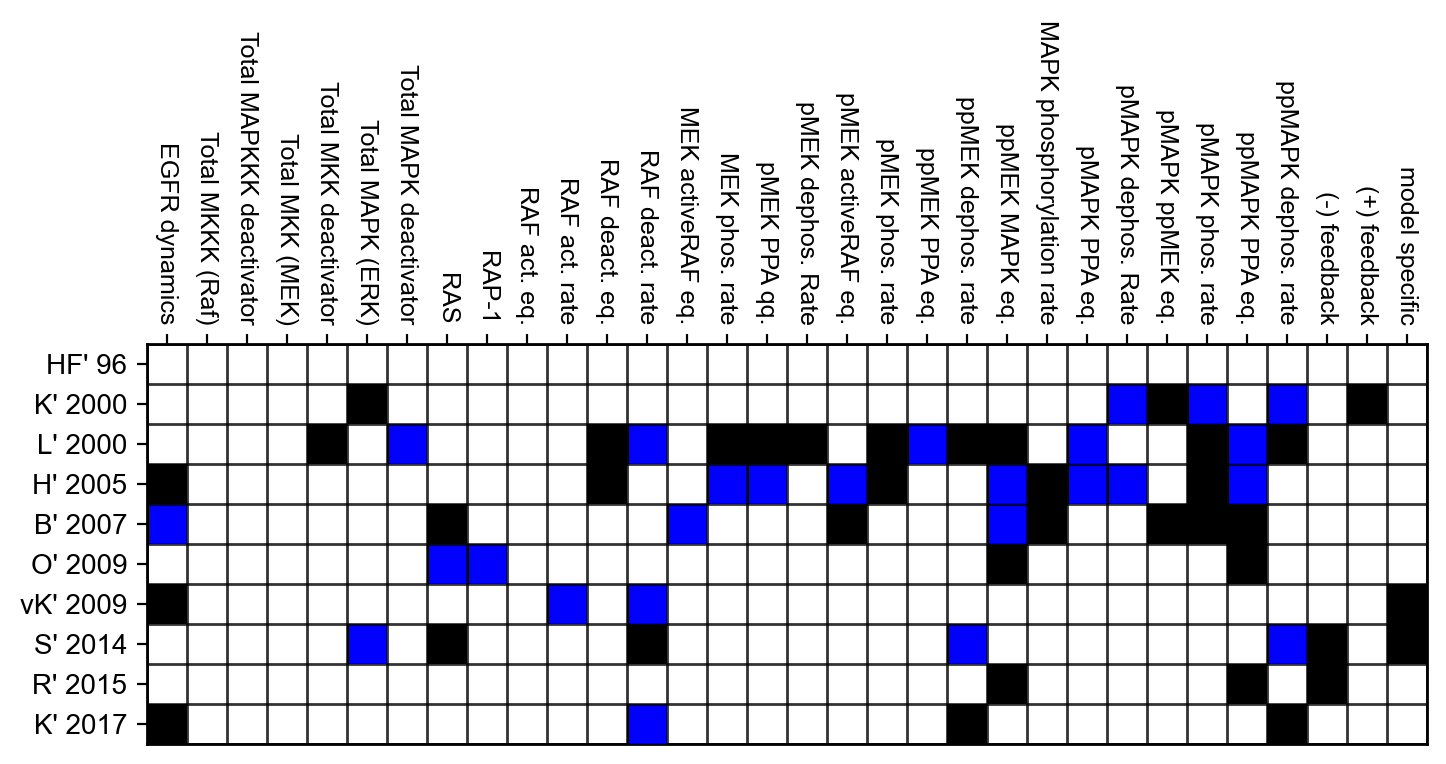

In [16]:
colors = np.array([[0,0,0],[1,1,1],[0,0,1]])
custom_cmap = ListedColormap(colors, name="my_cmap")

skip_cols = ['Param Type']
dat_df = pd.read_excel('../../../mmi_old_code/MAPK_model_tracker.xlsx', sheet_name='Quant-condens', usecols=lambda x: x not in skip_cols)
dat = dat_df.drop(columns=['Param Name']).to_numpy()

for i, row in enumerate(dat):
    for j, item in enumerate(row):
        if item == 'CYTO':
            dat[i,j] = 1.0
        elif item == 'PM':
            dat[i,j] = -1.0
        elif item == 'n.s.':
            dat[i,j] = np.nan
        elif item == 'both':
            dat[i,j] = 0.0
        elif item == 'nan':
            dat[i,j] = np.nan
            
dat = dat.astype(float)


fig, ax = get_sized_fig_ax(7.0,2.0)
lb = ["HF' 96",	"K' 2000",	"L' 2000",	"H' 2005",	"B' 2007",	"O' 2009",	"vK' 2009",	"S' 2014",	"R' 2015",	"K' 2017"]
im , cbar = heatmap(dat.T, row_labels=lb, col_labels=dat_df['Param Name'], ax=ax, cbarlabel='', 
        cbar_kw={'aspect':10, 'shrink':0.15, 'panchor':False, 'anchor':(0, 0),},
        cmap=custom_cmap)

cbar.remove()

fig.savefig(savedir + 'param_loc_heatmap.pdf', transparent=True, bbox_inches='tight')

In [18]:
dat_df

,Param Name,HF' 96,K' 2000,L' 2000,H' 2005,B' 2007,O' 2009,vK' 2009,S' 2014,R' 2015,K' 2017
0,EGFR dynamics,NaN,NaN,NaN,PM,CYTO,NaN,PM,NaN,NaN,PM
1,Total MKKK (Raf),NaN,NaN,n.s.,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Total MAPKKK deactivator,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Total MKK (MEK),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Total MKK deactivator,NaN,NaN,PM,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Total MAPK (ERK),NaN,PM,NaN,NaN,NaN,NaN,NaN,CYTO,NaN,NaN
6,Total MAPK deactivator,NaN,NaN,CYTO,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,RAS,NaN,NaN,NaN,NaN,PM,CYTO,NaN,PM,NaN,NaN
8,RAP-1,NaN,NaN,NaN,NaN,NaN,CYTO,NaN,NaN,NaN,NaN
9,RAF act. eq.,NaN,NaN,n.s.,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
skip_cols = []
dat_df = pd.read_excel('../../../mmi_old_code/MAPK_model_tracker.xlsx', sheet_name='comp-diff-table', usecols=lambda x: x not in skip_cols)
dat_df.rename(columns={"Param Type": "Function"}, inplace=True)
dat_df.rename(columns={"Param Name": "Parameter"}, inplace=True)
dat_df

,Parameter,Function,H' 1996,K' 2000,L' 2000,H' 2005,B' 2007,O' 2009,vK' 2009,S' 2014,R' 2015,K' 2017
0,"EGFR dephos,",EGFR dynamics,NaN,NaN,NaN,NaN,NaN,NaN,PM,NaN,NaN,NaN
1,pEGFR int.,EGFR dynamics,NaN,NaN,NaN,NaN,NaN,NaN,n.s.,NaN,NaN,NaN
2,pEGFR degrad.,EGFR dynamics,NaN,NaN,NaN,NaN,NaN,NaN,n.s.,NaN,NaN,NaN
3,EGFR deact.,EGFR dynamics,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PM
4,EGF EGFR unbinding,EGFR dynamics,NaN,NaN,NaN,n.s.,CYTO,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
82,PTP-1B Gab1-P (mem. loc.) unbinding,model specific,NaN,NaN,NaN,NaN,n.s.,NaN,NaN,NaN,NaN,NaN
83,Grb2 Shc-P (mem. loc.) unbinding,model specific,NaN,NaN,NaN,NaN,PM,NaN,NaN,NaN,NaN,NaN
84,Gab1 PIP3 unbinding,model specific,NaN,NaN,NaN,NaN,CYTO,NaN,NaN,NaN,NaN,NaN
85,Gap1 Grb2 (mem. loc.) unbinding,model specific,NaN,NaN,NaN,NaN,PM,NaN,NaN,NaN,NaN,NaN


In [48]:
print(dat_df.to_latex(index=False,
                caption="", 
                label="tab:kinetic_params_sd",
                column_format="c|c|c|c|c|c|c|c|c|c|c|c",
                bold_rows=True))

\begin{table}
\label{tab:kinetic_params_sd}
\begin{tabular}{c|c|c|c|c|c|c|c|c|c|c|c}
\toprule
Parameter & Function & H' 1996 & K' 2000 & L' 2000 & H' 2005 & B' 2007 & O' 2009 & vK' 2009 & S' 2014 & R' 2015 & K' 2017 \\
\midrule
EGFR dephos, & EGFR dynamics & NaN & NaN & NaN & NaN & NaN & NaN & PM & NaN & NaN & NaN \\
pEGFR int. & EGFR dynamics & NaN & NaN & NaN & NaN & NaN & NaN & n.s. & NaN & NaN & NaN \\
pEGFR degrad. & EGFR dynamics & NaN & NaN & NaN & NaN & NaN & NaN & n.s. & NaN & NaN & NaN \\
EGFR deact. & EGFR dynamics & NaN & NaN & NaN & NaN & NaN & NaN & NaN & NaN & NaN & PM \\
EGF EGFR unbinding & EGFR dynamics & NaN & NaN & NaN & n.s. & CYTO & NaN & NaN & NaN & NaN & NaN \\
EGFR int. & EGFR dynamics & NaN & NaN & NaN & n.s. & NaN & NaN & NaN & NaN & NaN & NaN \\
EGFR GAP binding & EGFR dynamics & NaN & NaN & NaN & PM & NaN & NaN & NaN & NaN & NaN & NaN \\
EGFR-GAP-Grb2-Sos Ras-GDP binding & EGFR dynamics & NaN & NaN & NaN & n.s. & NaN & NaN & NaN & NaN & NaN & NaN \\
Total R